In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time
# Main slim library
slim = tf.contrib.slim
%load_ext autoreload
%autoreload 2


AttributeError: module 'tensorflow' has no attribute 'contrib'

In [2]:
%pip install tensorflow-addons

   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   - ------------------------------------- 20.5/719.8 kB 640.0 kB/s eta 0:00:02
   - ------------------------------------- 30.7/719.8 kB 435.7 kB/s eta 0:00:02
   ---- ---------------------------------- 92.2/719.8 kB 751.6 kB/s eta 0:00:01
   ------ ------------------------------- 122.9/719.8 kB 722.1 kB/s eta 0:00:01
   ----------- ---------------------------- 215.0/719.8 kB 1.0 MB/s eta 0:00:01
   ----------------------- ---------------- 419.8/719.8 kB 1.5 MB/s eta 0:00:01
   ------------------------------ --------- 542.7/719.8 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 719.8/719.8 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
sys.path.append('/home/marcotcr/slim/models/slim')
sys.path.append('/home/marcotcr/phd/comparing_explanations/python')

In [6]:
from nets import inception
from preprocessing import inception_preprocessing
import anchor

In [7]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [8]:
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image_raw = tf.image.decode_jpeg(open(f).read(), channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [11]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()


AssertionError: 

In [9]:
# image = tf.image.decode_jpeg(open('maxresdefault.jpg').read(), channels=3)
# processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
# processed_images  = tf.expand_dims(processed_image, 0)


In [10]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [26]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = '/home/marcotcr/phd/comparing_explanations/notebooks/inception_tf'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)


In [27]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

In [ ]:
# def predict_fn(images):
#     with slim.arg_scope(inception.inception_v3_arg_scope()):
#         logits, _ = inception.inception_v3(images, num_classes=1001, is_training=False, reuse=True)
#     probabilities = tf.nn.softmax(logits)
#     return session.run([probabilities])[0]

In [13]:
import copy
from skimage.segmentation import quickshift, mark_boundaries, slic, felzenszwalb
def ShowImageNoAxis(image, boundaries=None, save=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if boundaries is not None:
        ax.imshow(mark_boundaries(image / 2 + 0.5, boundaries))
    else:
        ax.imshow(image / 2 + .5)
    if save is not None:
        plt.savefig(save)
    plt.show()

def show_exp(segments, exp, image, explainer):
    mask = np.ones(segments.shape).astype(bool)
    temp = copy.deepcopy(image)
    temp_img = copy.deepcopy(temp)
#     temp.img = temp.fudged_image.copy()
    temp[:] = 0
    # for x in exp_greedy[:3]:
    #     x = (x, x)
    for x in exp:
        temp[segments == x[0]] = temp_img[segments==x[0]]
    # temp.img[mask] = np.random.random(mask.nonzero()[0].shape[0] * 3).reshape(mask.nonzero()[0].shape[0], 3)
    print 'Anchor for prediction ', names[predict_fn(np.expand_dims(image, 0))[0].argmax()], 'confidence', exp[-1][2]
    ShowImageNoAxis(temp)
    print 'Counter Examples:'
    for e in exp[-1][3]:
        data = e[:-1]
        temp = explainer.dummys[e[-1]].copy()
        for x in data.nonzero()[0]:
            temp[segments == x] = image[segments == x]
        ShowImageNoAxis(temp)
        print 'Prediction = ', names[predict_fn(np.expand_dims(temp, 0))[0].argmax()]

def show_fudged_exp(segments, exp, image):
    fudged_image = image.copy()
    for x in np.unique(segments):
        fudged_image[segments == x] = (np.mean(image[segments == x][:, 0]),
                                       np.mean(image[segments == x][:, 1]),
                                       np.mean(image[segments == x][:, 2]))
    mask = np.ones(segments.shape).astype(bool)
    temp = copy.deepcopy(image)
    temp_img = copy.deepcopy(temp)
#     temp.img = temp.fudged_image.copy()
    temp[:] = 0
    # for x in exp_greedy[:3]:
    #     x = (x, x)
    for x in exp:
        temp[segments == x[0]] = temp_img[segments==x[0]]
    # temp.img[mask] = np.random.random(mask.nonzero()[0].shape[0] * 3).reshape(mask.nonzero()[0].shape[0], 3)
    print 'Anchor for prediction ', names[predict_fn(np.expand_dims(image, 0))[0].argmax()], 'confidence', exp[-1][2]
    ShowImageNoAxis(temp)
    print 'Counter Examples:'
    for e in exp[-1][3]:
        data = e
        temp = fudged_image.copy()
        for x in data.nonzero()[0]:
            temp[segments == x] = image[segments == x]
        ShowImageNoAxis(temp)
        print 'Prediction = ', names[predict_fn(np.expand_dims(temp, 0))[0].argmax()]

In [14]:
import skimage.io
import skimage.transform
def transform_img_fast(path):
    img = skimage.io.imread(path)
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy: yy + short_egde, xx: xx + short_egde]
    return (skimage.transform.resize(crop_img, (299, 299)) - 0.5) * 2
def transform_img_fn_fast(paths):
    out = []
    for i, path in enumerate(paths):
        if i % 100 == 0:
            print i
        out.append(transform_img_fast(path))
    return np.array(out)
#     return np.array([transform_img_fast(path) for path in paths])

In [33]:
a = time.time()
images = transform_img_fn(['zebra.jpg', 'zebra.jpg'])
print time.time() - a


0.351321935654


(299, 299, 3)

In [13]:
img = images[-1]

In [37]:
np.array(images).shape

(2, 299, 299, 3)

In [31]:
a = time.time()
probs = predict_fn(np.array(images))
print time.time() -a 

0.0239930152893


In [32]:
probs

array([[  3.86033535e-05,   5.42633243e-05,   4.07462503e-05, ...,
          2.10330018e-05,   5.93606346e-05,   1.15921175e-04],
       [  3.86033535e-05,   5.42633243e-05,   4.07462503e-05, ...,
          2.10330018e-05,   5.93606346e-05,   1.15921175e-04]], dtype=float32)

In [42]:
probs.shape

(2, 1001)

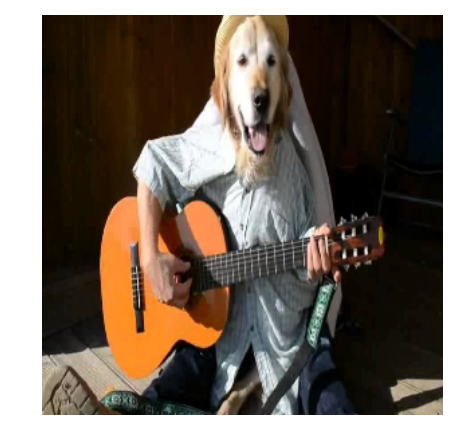

'acoustic guitar'

In [44]:
i = 1
ShowImageNoAxis(images[i])
names[np.argmax(probs[i])]

In [3]:
image = images[0]

NameError: name 'images' is not defined

In [1]:
3

3

In [22]:
explainer = anchor.AnchorImage([], '/Users/marcotcr/phd/datasets/imagenet/full',
                               transform_img_fn=transform_img_fn_fast, n=5000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [18]:
# explainer2 = anchor.AnchorImage([])


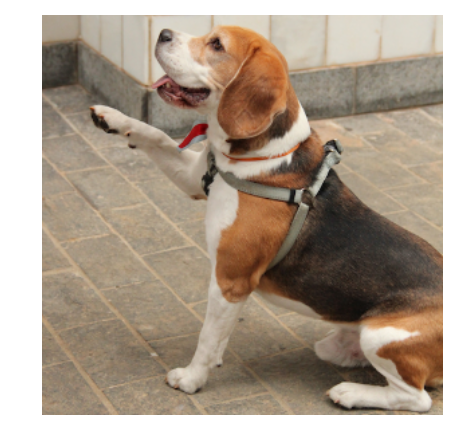

In [279]:
# image = transform_img_fast('/home/marcotcr/phd/datasets/visualqa/val2014/COCO_val2014_000000045626.jpg')
image = transform_img_fast('nick.jpg')
ShowImageNoAxis(image)

In [46]:
z = predict_fn([image])
print names[z.argmax()], z.max()

beagle 0.945151


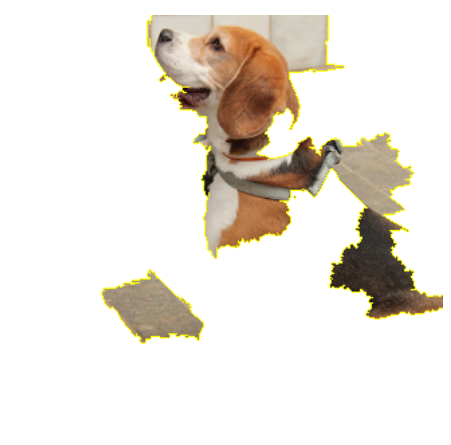

In [278]:
from skimage.segmentation import quickshift
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)
exp = {}
# exp['feature'] =  [1, 2, 7, 8, 9, 11, 16, 17, 24, 25, 28, 29, 30, 34, 36, 39, 40, 52]
exp['feature'] = [1, 2, 7, 8, 9, 11, 17, 25, 29, 30, 34, 36, 40, 52]
temp = np.ones(image.shape)
mask = np.zeros(segments.shape).astype(bool)
for f in exp['feature']:
    mask[segments == f] = 1
temp[mask] = image[mask].copy()
ShowImageNoAxis(temp, mask, '/tmp/nickz.png')

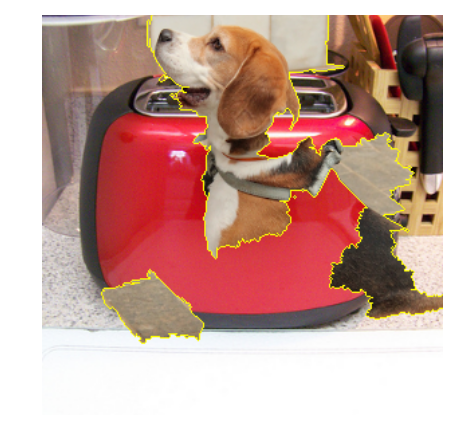

beagle 0.912143


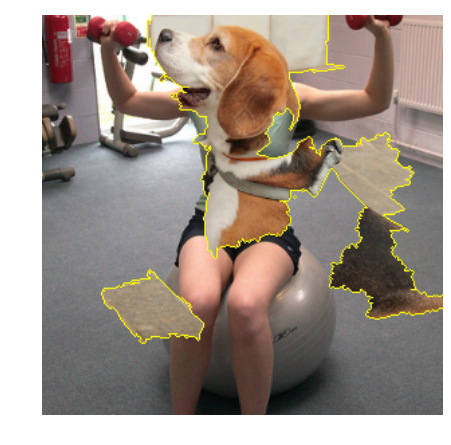

beagle 0.98032


In [276]:
N = 5
chosen = np.random.choice(len(explainer.dummys), N)
imgs = []
masks = []
for c in chosen:
    temp = copy.deepcopy(explainer.dummys[c])
    mask = np.zeros(segments.shape).astype(bool)
    for f in exp['feature']:
        mask[segments == f] = 1
    temp[mask] = image[mask].copy()
    imgs.append(temp)
    masks.append(mask)
preds = predict_fn(imgs)
for i, p in zip(imgs, preds):
    if p.max() < 0.9:
        continue
    ShowImageNoAxis(i, mask, '/tmp/nickz.png')
    print names[p.argmax()], p.max()


In [ ]:
(1, 2, 7, 8, 9, 11, 16, 17, 24, 25, 28, 29, 30, 34, 36, 39, 40, 52) mean = 0.97 lb = 0.92 ub = 0.99 coverage: 0.00

In [ ]:
# (1, 2, 7, 8, 9, 11, 17, 25, 29, 30, 34, 36, 40, 52) mean 0.95
# (1, 2, 7, 8, 9, 11, 16, 17, 25, 29, 30, 34, 36, 40, 52) mean = 0.90 lb = 0.87 ub = 0.93 coverage: 0.00
# (1, 2, 7, 8, 9, 11, 16, 17, 24, 25, 29, 30, 34, 36, 40, 52) mean = 0.94 lb = 0.90 ub = 0.97 coverage: 0.00
# (1, 2, 7, 8, 9, 11, 16, 17, 24, 25, 28, 29, 30, 34, 36, 39, 40, 52) mean = 0.97 lb = 0.92 ub = 0.99 coverage: 0.00


In [47]:
segments, exp = explainer.explain_hoeffding(image, predict_fn, threshold=0.95, batch_size=10,
                                            tau=0.20, verbose=True, min_shared_samples=200, beam_size=1)
# segments_f, exp_f = explainer2.explain_hoeffding(image, predict_fn, threshold=0.95, batch_size=20,
#                                             tau=0.1, verbose=True, min_shared_samples=100, new=True)

True pred 163
Best: 19 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 0 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0909090909, n: 11, lb:0.0000) Worst: 51 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0476190476, n: 21, lb:0.0000) Worst: 50 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0322580645, n: 31, lb:0.0000) Worst: 49 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0243902439, n: 41, lb:0.0000) Worst: 48 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0196078431, n: 51, lb:0.0000) Worst: 47 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0163934426, n: 61, lb:0.0000) Worst: 46 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0140845070, n: 71, lb:0.0000) Worst: 52 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0123456790, n: 81, lb:0.0000) Worst: 45 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0109890110, n: 91, lb:0.0000) Worst: 43 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:0.0

KeyboardInterrupt: 

In [27]:
exp

NameError: name 'exp' is not defined

In [ ]:
image2 = transform_img_fn(['zebra.jpg'])[0]
segments2, exp2 = explainer.explain_hoeffding(image2, predict_fn, threshold=0.95, batch_size=10,
                                            tau=0.15, verbose=False, min_shared_samples=200, beam_size=1)

In [214]:
def random_examples_from_exp(segments, exp, image, explainer, n=5):
    n_features = len(np.unique(segments))
    data = np.random.choice(
        [0, 1], n * n_features, p=[.8, .2]).reshape(
        (n, n_features))
    present = np.array([x[0] for x in exp])
    data[:, present] = 1
    chosen = np.random.choice(range(len(explainer.dummys)), data.shape[0],
                              replace=True)
    imgs = []
    for d, r in zip(data, chosen):
        temp = copy.deepcopy(image)
        zeros = np.where(d == 0)[0]
        mask = np.zeros(segments.shape).astype(bool)
        for z in zeros:
            mask[segments == z] = True
        chosen = np.random
        temp[mask] = explainer.dummys[r][mask]
        imgs.append(temp)
    preds = predict_fn(np.array(imgs))
    preds_max = np.argmax(preds, axis=1)
    preds_val = np.max(preds, axis=1)
    for img, pred, val in zip(imgs, preds_max, preds_val):
        ShowImageNoAxis(img)
        print names[pred], val

Anchor for prediction  zebra confidence 0.95


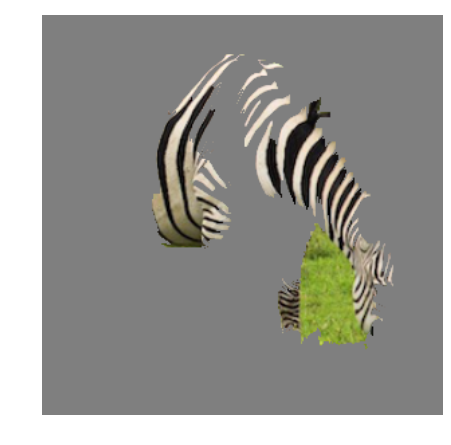

Counter Examples:


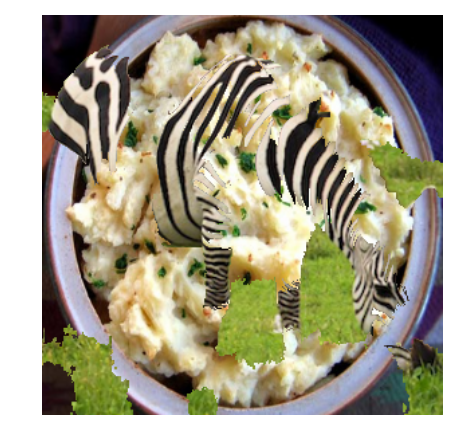

Prediction =  mashed potato


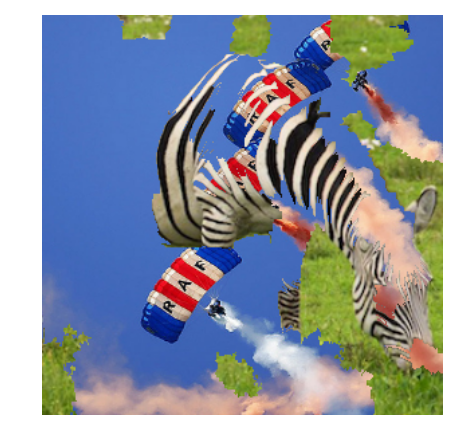

Prediction =  parachute, chute


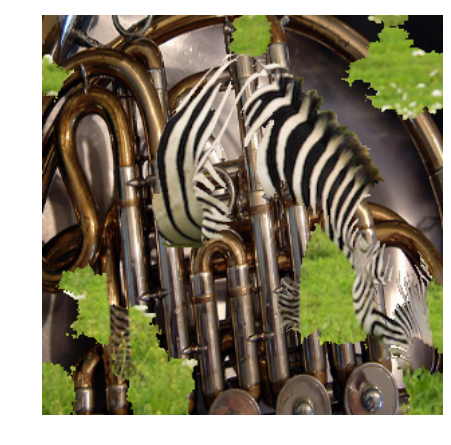

Prediction =  French horn, horn


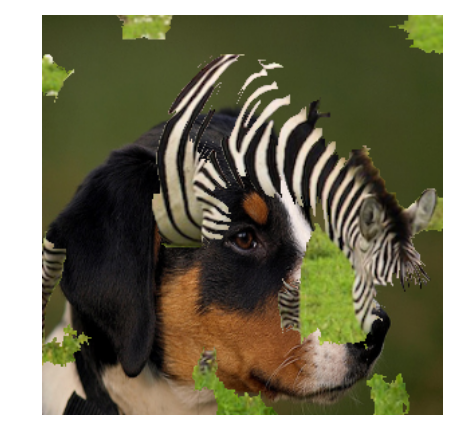

Prediction =  Appenzeller


In [49]:
# show_fudged_exp(segments_f, exp_f, image)
show_exp(segments, exp, image, explainer)

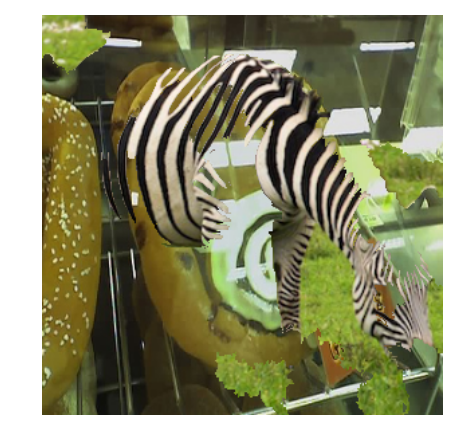

zebra 0.62114


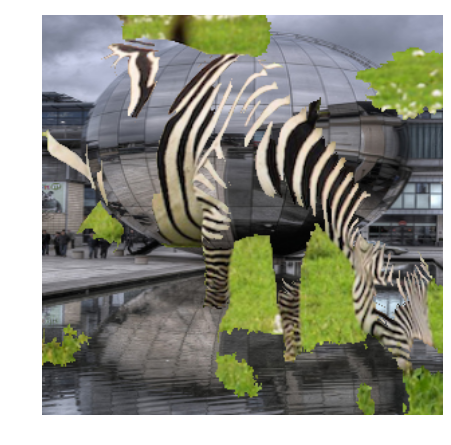

zebra 0.83558


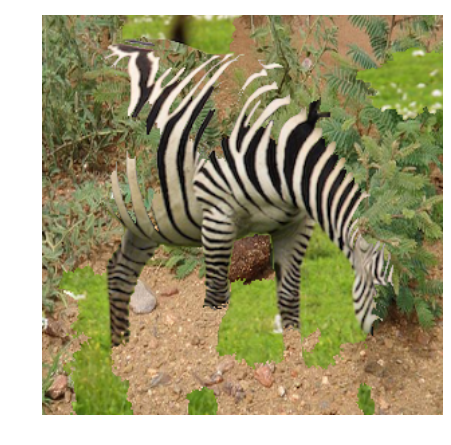

zebra 0.932653


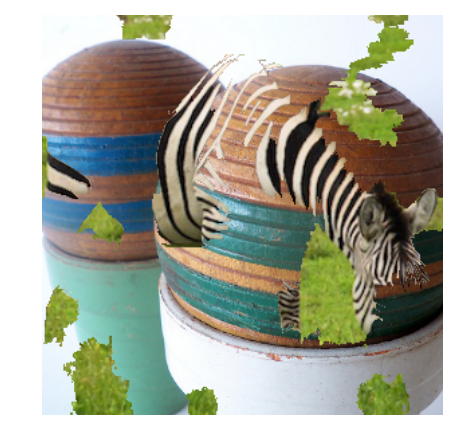

sombrero 0.313277


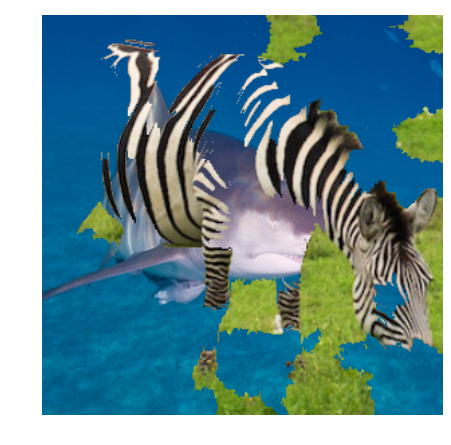

zebra 0.945059


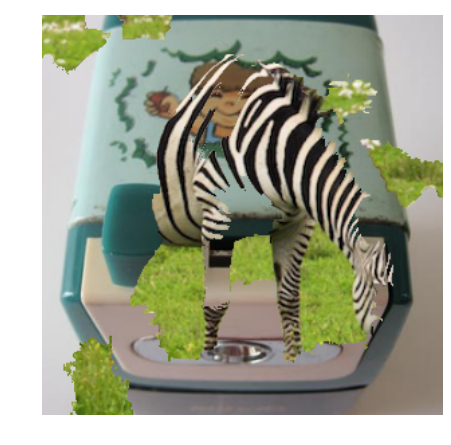

zebra 0.937853


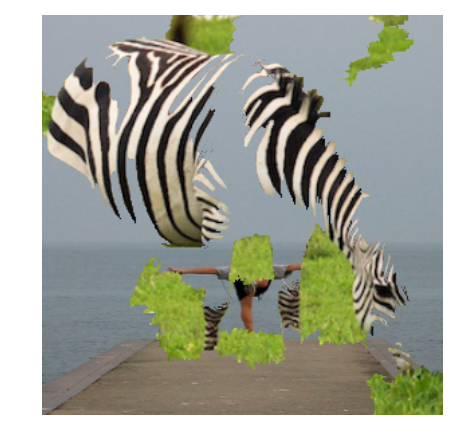

zebra 0.928237


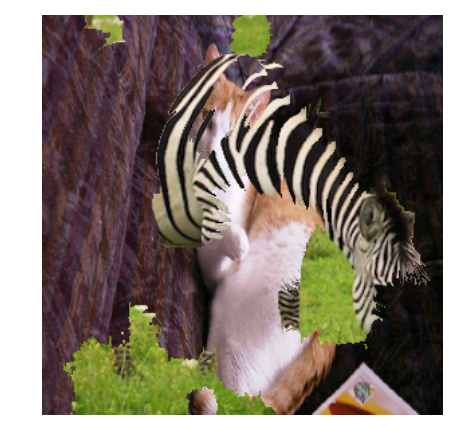

zebra 0.958959


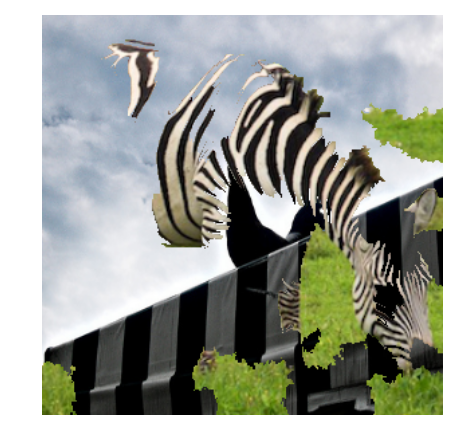

zebra 0.721748


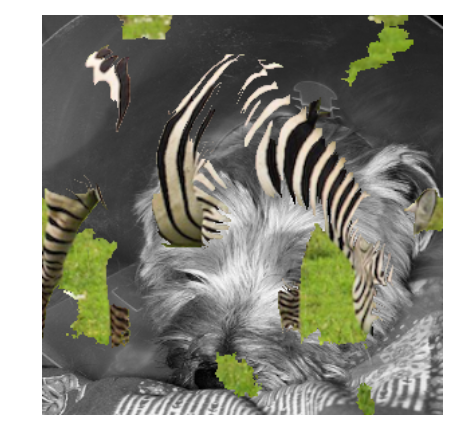

zebra 0.413454


In [50]:
izz = random_examples_from_exp(segments, exp, image, explainer, n=10)

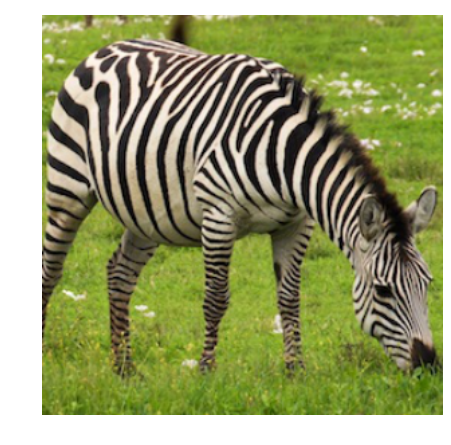

In [63]:
ShowImageNoAxis(image)

In [33]:
a = time.time()
samples = fn([], 20)
print time.time() - a

6.43345284462


In [ ]:
explainer.

In [38]:
6.05 / len(ret)

0.3025

In [39]:
[names[i] for i in probs.argmax(axis=1)]

['acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever',
 'acoustic guitar',
 'golden retriever']

In [30]:
# import time
# image = tf.image.decode_jpeg(open('maxresdefault.jpg').read(), channels=3)
# processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
# processed_images  = tf.expand_dims(processed_image, 0)
# images
a = time.time()
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False, reuse=True)
probabilities = tf.nn.softmax(logits)
np_image, probabilities = session.run([image, probabilities])
probabilities = probabilities[0, 0:]
print time.time() - a

1.60762500763


In [ ]:
# images = processed_images.eval()
# images = np.vstack((images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images, images))
a = time.time()
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(images[:20], num_classes=1001, is_training=False, reuse=True)
probabilities = tf.nn.softmax(logits)
np_image, probabilities = session.run([image, probabilities])
# probabilities = probabilities[0, 0:]
print time.time() - a

In [131]:
6.36 / 20.

0.318

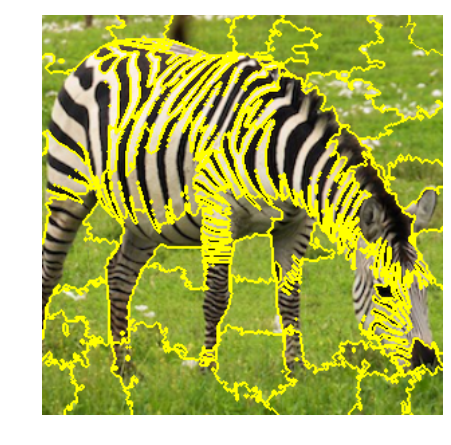

In [26]:
from skimage.segmentation import quickshift, mark_boundaries, slic, felzenszwalb
segments = quickshift(image, kernel_size=5, max_dist=200, ratio=0.5)
fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(mark_boundaries(image / 2. + .5,segments))
plt.show()

In [27]:
np.unique(segments).shape

(48,)

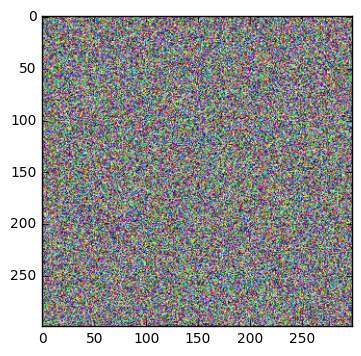

In [124]:
plt.imshow(images[0] / 2. + 0.5)

In [122]:
[names[np.argmax(i)] for i in probabilities]

['envelope',
 'envelope',
 'envelope',
 'envelope',
 'envelope',
 'envelope',
 'envelope',
 'bee eater',
 'envelope',
 'envelope',
 'envelope',
 'bee eater',
 'envelope',
 'envelope',
 'envelope',
 'kite',
 'envelope',
 'envelope',
 'envelope',
 'kite',
 'envelope',
 'kite',
 'switch, electric switch, electrical switch',
 'envelope',
 'kite',
 'envelope',
 'envelope',
 'envelope',
 'envelope',
 'kite']

In [11]:
import os
checkpoints_dir = '/home/marcotcr/phd/comparing_explanations/notebooks/inception_tf'
init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
        slim.get_model_variables('InceptionV3'))
init_fn(session)


NotFoundError: Tensor name "InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/biases" not found in checkpoint files /home/marcotcr/phd/comparing_explanations/notebooks/inception_tf/inception_v3.ckpt
	 [[Node: save_1/RestoreV2_182 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_182/tensor_names, save_1/RestoreV2_182/shape_and_slices)]]

Caused by op u'save_1/RestoreV2_182', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-eb3fd5e447b6>", line 5, in <module>
    slim.get_model_variables('InceptionV3'))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/variables.py", line 560, in assign_from_checkpoint_fn
    saver = tf_saver.Saver(var_list, reshape=reshape_variables)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 1003, in __init__
    self.build()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 1032, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 625, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 362, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 201, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 439, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 748, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2388, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1300, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/biases" not found in checkpoint files /home/marcotcr/phd/comparing_explanations/notebooks/inception_tf/inception_v3.ckpt
	 [[Node: save_1/RestoreV2_182 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_182/tensor_names, save_1/RestoreV2_182/shape_and_slices)]]


0.858725070953


In [13]:
names[probabilities.argmax()]

NameError: name 'probabilities' is not defined

In [14]:
probabilities

array([ 0.0001981 ,  0.00027717,  0.00020775, ...,  0.0001119 ,
        0.00015019,  0.00030671], dtype=float32)

In [14]:
logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

NameError: name 'processed_images' is not defined

FailedPreconditionError: Attempting to use uninitialized value InceptionV3/Conv2d_1a_3x3/weights
	 [[Node: InceptionV3/Conv2d_1a_3x3/weights/read = Identity[T=DT_FLOAT, _class=["loc:@InceptionV3/Conv2d_1a_3x3/weights"], _device="/job:localhost/replica:0/task:0/cpu:0"](InceptionV3/Conv2d_1a_3x3/weights)]]

Caused by op u'InceptionV3/Conv2d_1a_3x3/weights/read', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-21fb5b487d72>", line 1, in <module>
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
  File "/home/marcotcr/slim/models/slim/nets/inception_v3.py", line 479, in inception_v3
    depth_multiplier=depth_multiplier)
  File "/home/marcotcr/slim/models/slim/nets/inception_v3.py", line 102, in inception_v3_base
    net = slim.conv2d(inputs, depth(32), [3, 3], stride=2, scope=end_point)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 753, in convolution2d
    trainable=trainable)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/variables.py", line 249, in model_variable
    caching_device=caching_device, device=device)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/variables.py", line 213, in variable
    caching_device=caching_device)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 1024, in get_variable
    custom_getter=custom_getter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 850, in get_variable
    custom_getter=custom_getter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 346, in get_variable
    validate_shape=validate_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 331, in _true_getter
    caching_device=caching_device, validate_shape=validate_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 677, in _get_single_variable
    expected_shape=shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 219, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 350, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1143, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 748, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2388, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1300, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value InceptionV3/Conv2d_1a_3x3/weights
	 [[Node: InceptionV3/Conv2d_1a_3x3/weights/read = Identity[T=DT_FLOAT, _class=["loc:@InceptionV3/Conv2d_1a_3x3/weights"], _device="/job:localhost/replica:0/task:0/cpu:0"](InceptionV3/Conv2d_1a_3x3/weights)]]


In [70]:
images[0]

array([[[  2.70588279e-01,   4.03921604e-01,  -3.49019587e-01],
        [  1.52862549e-01,   2.93120861e-01,  -4.80595410e-01],
        [  1.07220173e-01,   2.60410547e-01,  -5.04046142e-01],
        ..., 
        [  4.15358186e-01,   5.69466829e-01,  -1.28572524e-01],
        [  4.23435569e-01,   5.74291587e-01,  -1.38438225e-01],
        [  3.33333373e-01,   4.90196109e-01,  -2.70588219e-01]],

       [[  4.97226238e-01,   5.95147371e-01,  -1.61452889e-02],
        [  3.29473257e-01,   4.40572858e-01,  -1.78988039e-01],
        [  1.90409184e-01,   3.15269828e-01,  -3.63889813e-01],
        ..., 
        [  4.18059111e-01,   5.67572355e-01,  -1.32954061e-01],
        [  3.50953102e-01,   5.03467321e-01,  -2.21319616e-01],
        [  2.55426645e-01,   4.19371843e-01,  -3.69742274e-01]],

       [[  4.45708036e-01,   5.39825678e-01,  -4.36093807e-02],
        [  3.45144272e-01,   4.41948533e-01,  -1.42829716e-01],
        [  2.00824261e-01,   3.24523807e-01,  -3.60401154e-01],
        

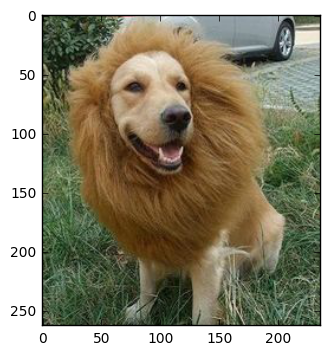

In [32]:
plt.imshow(image.eval().astype(np.uint8))

In [29]:
processed_image.eval()

array([[[-0.71764708, -0.59215683, -0.79607844],
        [-0.69582266, -0.55942023, -0.76334184],
        [-0.72924125, -0.58806479, -0.77971017],
        ..., 
        [ 0.89667523,  0.81244683,  0.6549021 ],
        [ 0.90281343,  0.80699074,  0.6549021 ],
        [ 0.90588248,  0.8039217 ,  0.6549021 ]],

       [[-0.70552826, -0.58003801, -0.78395957],
        [-0.54460078, -0.40819836, -0.61211997],
        [-0.46499813, -0.3238216 , -0.51546699],
        ..., 
        [ 0.89667523,  0.81244683,  0.65595603],
        [ 0.90281343,  0.80699074,  0.6549021 ],
        [ 0.90588248,  0.8039217 ,  0.6549021 ]],

       [[-0.71906352, -0.58502197, -0.78894353],
        [-0.56477827, -0.42577332, -0.62969488],
        [-0.49782252, -0.356646  , -0.54829139],
        ..., 
        [ 0.90095091,  0.81672251,  0.66834962],
        [ 0.90448654,  0.813869  ,  0.66252387],
        [ 0.90588248,  0.81247306,  0.65917778]],

       ..., 
       [[-0.61033499, -0.41924042, -0.64419949],
        

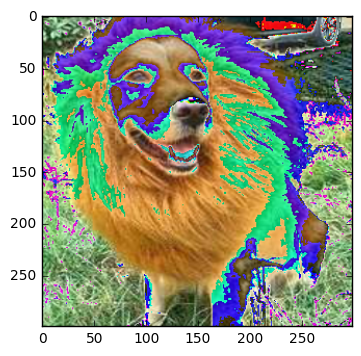

In [25]:
plt.imshow(processed_image.eval())

TypeError: Image data can not convert to float

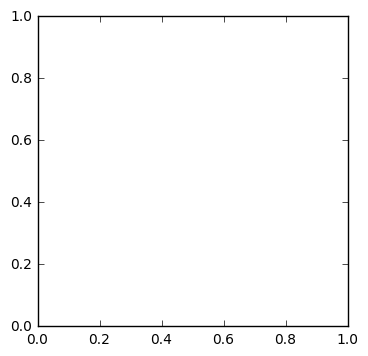

In [15]:
plt.imshow(image)

In [13]:
image.eval().shape

(263, 236, 3)

In [2]:
model_dir = 'inception'

In [5]:
image = os.path.join(model_dir, 'cropped_panda.jpg')

In [3]:
image = 'doglion.jpg'
image_data = tf.gfile.FastGFile(image, 'rb').read()


In [10]:
a = tf.cast(image_data, tf.float32)

In [13]:
sess = tf.Session()

In [15]:
sess.run(a)

UnimplementedError: Cast string to float is not supported
	 [[Node: Cast_4 = Cast[DstT=DT_FLOAT, SrcT=DT_STRING, _device="/job:localhost/replica:0/task:0/cpu:0"](Cast_4/x)]]
Caused by op u'Cast_4', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-c8316e3f0d7f>", line 1, in <module>
    a = tf.cast(image_data, tf.float32)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 625, in cast
    return gen_math_ops.cast(x, base_type, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 408, in cast
    result = _op_def_lib.apply_op("Cast", x=x, DstT=DstT, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


In [9]:
image_data

'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00d\x00d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x04\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x04\x05\x07\x01\x02\x03\x08\xff\xc4\x005\x10\x00\x02\x01\x03\x02\x04\x05\x01\x06\x06\x03\x01\x00\x00\x00\x00\x01\x02\x03\x00\x04\x11\x05!\x06\x121A\x13"Qaq\x91\x072\x81\xa1\xb1\xc1\x14\x15#BR\xf0b\xd1\xe1\xf1\xff\xc4\x00\x19\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x00\x01\x05\xff\xc4\x00\x1f\x11\x00\x02\x02\x03\x01\x01\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11\x03\x12!1\x13\x042Q\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\